# 第六次计算物理作业

学号： 2021300002018

姓名： 朱向阳

## 使用vpython绘制行星运动及表面温度模拟

右边实时动画，绿线实时温度

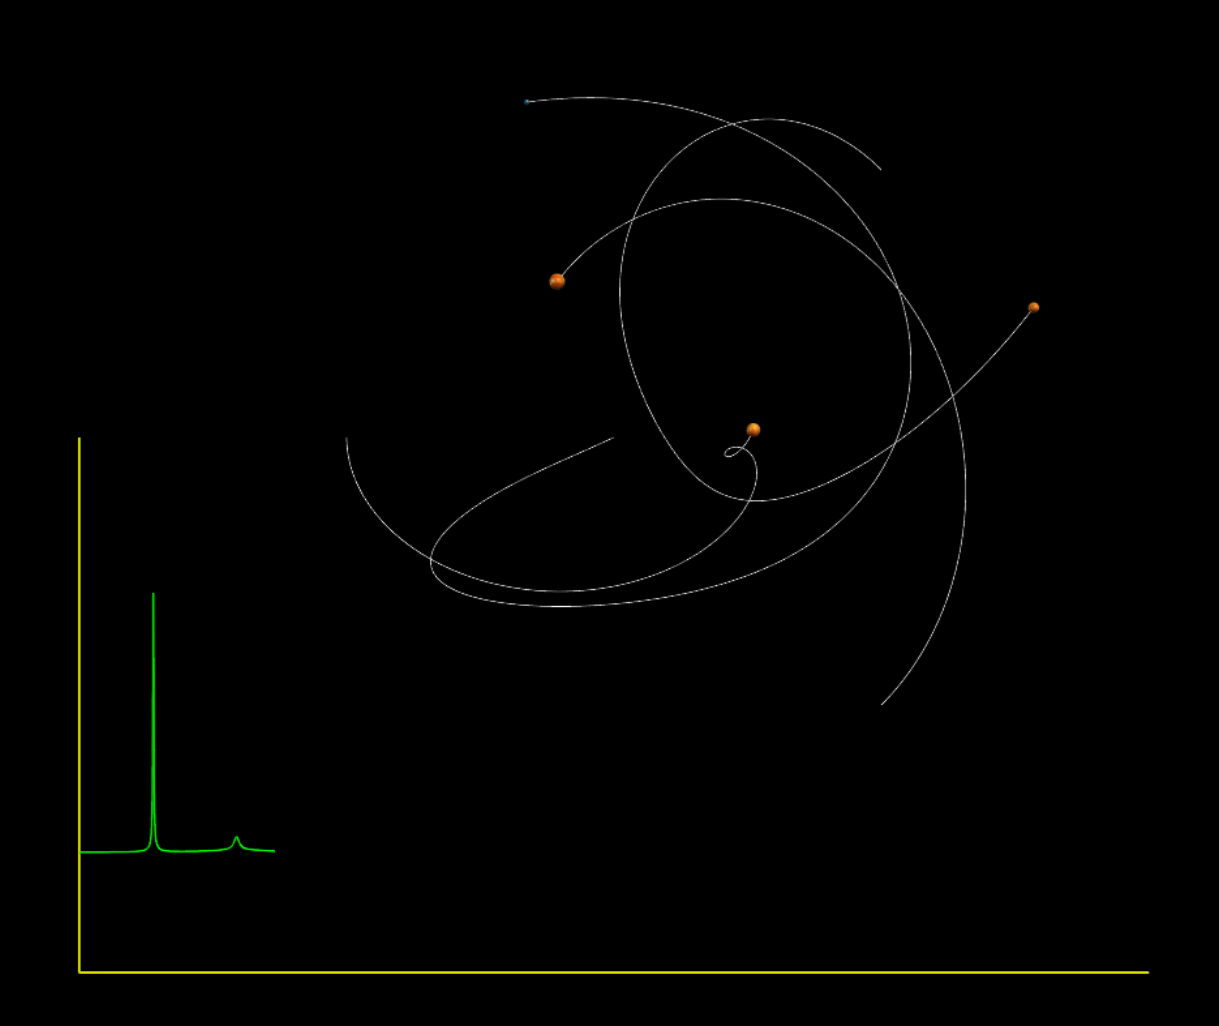

In [1]:
import vpython as vp
import numpy as np
import os 
import scipy
import matplotlib.pyplot as plt
import pandas

<IPython.core.display.Javascript object>

In [2]:
info = {'sun1': {'index': 1, 'texture': 'Sun_texture.jpg', 'm': 1000, 'pos': vp.vector(50,50,0), 'r': 1, 'p': vp.vector(-2000,2000,0), 'rotate':0.3, 'trail_c': vp.color.white, 'rotate_axis':vp.vector(0, 1, 0)},
        'sun2': {'index': 2, 'texture': 'Sun_texture.jpg', 'm': 1500, 'pos': vp.vector(50,-50,0), 'r': 1.5, 'p': vp.vector(3000,3000,0), 'rotate':0.1, 'trail_c': vp.color.white, 'rotate_axis':vp.vector(0, 1, 0)}, 
        'sun3': {'index': 3, 'texture': 'Sun_texture.jpg', 'm': 1300, 'pos': vp.vector(-50,0,0), 'r': 1.3, 'p': vp.vector(0,-2400,0), 'rotate':0.2, 'trail_c': vp.color.white, 'rotate_axis':vp.vector(0, 1, 0)}, 
         'earth': {'index': 4, 'texture': 'earth_texture.jpg', 'm': 0.5, 'pos': vp.vector(0,0,0), 'r': 0.5, 'p': vp.vector(0,0,0), 'rotate':0.4, 'trail_c': vp.color.white, 'rotate_axis':vp.vector(0, -1, 0)}}

# 星球信息列表

texture_url = {'sun1':'https://s2.loli.net/2023/10/10/wnQK3Y2xj54vf6I.jpg',
               'sun2':'https://s2.loli.net/2023/10/10/wnQK3Y2xj54vf6I.jpg',
               'sun3':'https://s2.loli.net/2023/10/10/wnQK3Y2xj54vf6I.jpg',
               'earth':'https://s2.loli.net/2023/10/10/fxpiz7IT5qtC2us.jpg'
              }
# 因为提交的ipynb,故使用图床加载材质

In [9]:
scene = vp.canvas(title="Solar System", width=1000, height=1000, x=0, y=0,
               center=vp.vector(0, 0, 0), background=vp.color.black)

# scene.range = 1

stars_name = list(info.keys())
index = np.arange(0,4) # 因为月球的数值很难调整合适，故暂不画月球
stars_name = np.array(stars_name)[index]
# stars = [vp.sphere(pos=info[star]['pos'], radius=info[star]['r'], mass=info[star]['m'], momentum=info[star]['p'], 
#          texture=info[star]['texture'], make_trail=True, trail_radius=0.005) for star in stars_name]
stars = [vp.sphere(pos=info[star]['pos'], radius=info[star]['r'], mass=info[star]['m'], momentum=info[star]['p'], 
         texture={'file':texture_url[star]}, make_trail=True, trail_radius=0.1) for star in stars_name]

star_num = len(stars)
rotate_speed = np.array([x['rotate'] for x in info.values()])[index] #自转速度
rotate_angle = np.zeros(star_num) # 转角
rotate_axis = np.array([x['rotate_axis'] for x in info.values()])[index] #转轴
scene.waitfor("textures")
scene.visible

G = 1 #暂定为1 

R = 0.2
d = 100
xaxis = vp.cylinder(pos=vp.vector(-d,-d,0), axis=vp.vector(2*d,0,0), radius=R, color=vp.color.yellow)
yaxis = vp.cylinder(pos=vp.vector(-d,-d,0), axis=vp.vector(0,d,0), radius=R, color=vp.color.yellow)

Tk = 10000
T = vp.curve(color=vp.color.green, radius=0.2) 

def update_pos(G, star_num, pos, mass, momentum, dt):
#更新坐标函数，用numpy加速计算

    mass_matrix = (mass.reshape(star_num, 1) * mass)[~ np.eye(star_num,dtype=bool)].reshape(star_num, star_num-1, 1)
    # 计算m1*m2矩阵，同时删去对角元素
    bool_matrix = ~ np.repeat(np.eye(star_num,dtype=bool).reshape(star_num, star_num, 1), 3, axis=2)
    rvector_matrix = np.tile(pos, (star_num, 1, 1)).transpose(1,0,2) - np.tile(pos, (star_num, 1, 1))
    # 计算r1-r2矩阵， rvector_matrix: r_ij = pos_i - pos_j
    rvector_diag = rvector_matrix[bool_matrix].reshape(star_num, star_num-1, 3)
    # 删去对角
    mag_matrix = np.linalg.norm(rvector_diag, axis=2, keepdims=True)
    F_matrix = - G * rvector_diag * mass_matrix / mag_matrix**3
    # 计算引力矩阵
    Force = np.sum(F_matrix, axis=1)
    momentum = momentum + Force * dt
    pos = pos + momentum / mass.reshape(star_num, 1) * dt
    # 合并计算新坐标
    T = -273.15 + np.sum(Tk / mag_matrix**2)
    return pos, momentum, T

<IPython.core.display.Javascript object>

In [ ]:
t = 0
dt = 0.00001 # 时间步进
j = 0
while(True):
    vp.rate(10000000)
    
    pos = np.array([star.pos.value for star in stars])
    mass = np.array([star.mass for star in stars])
    momentum = np.array([star.momentum.value for star in stars])
    # vpython.vector转换为numpy数组
    
    pos, momentum, Ts = update_pos(G, star_num, pos, mass, momentum, dt)
    rotate_angle += rotate_speed * dt * 0.001 #  控制自转

    for i in range(star_num):
        stars[i].pos = vp.vector(pos[i][0], pos[i][1], pos[i][2])
        stars[i].momentum = vp.vector(momentum[i][0], momentum[i][1], momentum[i][2])
        stars[i].rotate(angle=rotate_angle[i], axis=rotate_axis[i]) 
    # 更新对象信息
    
    t += dt 
    
    j += 1
#     print(j)
    if j % 1000 == 0:
#         print(-d+t,-d*4/3-Ts/5)
        T.append(vp.vector(-d+t,-d*3/4+Ts/100,0))
    
#     poscenter = np.mean(pos, axis=0)
#     centers = vp.vector(poscenter[0], poscenter[1], poscenter[2])
#     scene.center = centers
#     xaxis.center = centers + vp.vector(-d,-d,0)
#     yaxis.center = centers + vp.vector(-d,-d,0)

#     scene.camera.rotte(angle = dt*8*0.3, axis = vp.vector(-1,0,0)) 
    
#     scene.center = vp.vector(0,0,0)# 控制摄像机视角缩放3